<a id = 'top'></a>

# Crime in Boston

**Ying Zhou**

**This report is an on-going work.**

[1. Data Wrangling](#data_wrangling)

[1.1 Dropping non-crimes](#drop3)

[2. Preliminary Analysis](#pre_anal)

[2.1 Crime and day of the week](#day)

[2.2 Is the crime problem in Boston getting better or worse?](#year)

[2.3 Crime and month](#month)

[2.4 What are the most common crimes in Boston?](#common)

[2.5 Where are crimes located in Boston?](#location)

[2.6 What time of day are crimes commited?](#time)

[2.7 How many crimes involve shooting?](#shooting)

[3. Crime rates of neighborhoods of Boston](#crime_rates)

[3.1 Calculate the population of each neighborhood of Boston](#3.0)

[3.2 Determining the neighborhood in which a crime took place](#3.1)

[3.3 Calculate the crime rates](#3.2)

[3.3 Graphs](#3.3)

[4. Predict the crime rates in Boston](#predict)

[5. Conclusion](#conclusion)

Let's first import the usual packages.

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Time to get the data!

In [4]:
df = pd.read_csv('crime.csv')

In [5]:
df.shape

(358066, 17)

In [6]:
df.head(5)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,location
0,I192006902,1402,Vandalism,VANDALISM,C11,364.0,NaN,2019-01-25 22:30:00,2019,1,Friday,22,Part Two,CENTRE ST,42.295064,-71.056725,"(42.29506405, -71.05672533)"
1,I192006833,522,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,794.0,NaN,2019-01-25 12:41:00,2019,1,Friday,12,Part One,GLENVILLE AVE,42.349780,-71.134230,"(42.34977988, -71.13423049)"
2,I192006763,619,Larceny,LARCENY ALL OTHERS,C11,333.0,NaN,2019-01-09 11:14:00,2019,1,Wednesday,11,Part One,MOUNT EVERETT ST,42.310136,-71.070293,"(42.31013569, -71.07029310)"
3,I192006685,3301,Verbal Disputes,VERBAL DISPUTE,A15,58.0,NaN,2019-01-25 23:23:00,2019,1,Friday,23,Part Three,PHIPPS ST,42.376370,-71.067591,"(42.37637003, -71.06759097)"
4,I192006619,619,Larceny,LARCENY ALL OTHERS,B2,280.0,NaN,2019-01-25 17:53:00,2019,1,Friday,17,Part One,DUDLEY ST,42.328632,-71.083099,"(42.32863172, -71.08309899)"


<a id = 'data_wrangling'></a>
[Return to top](#top)
# 1. Data Wrangling

Since `incident_number` is unique let's make it the index. Then we should drop `location` due to redundancy. Moreover we need to fill the NaNs in `shooting` because NaNs in this case indicate the absence of shooting in the crime.

In [7]:
df.set_index('incident_number', inplace = True)
df['shooting'].fillna(0, inplace = True)
df.drop(columns = ['location'], inplace = True)

In [8]:
df.head(5)

,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long
incident_number,,,,,,,,,,,,,,,
I192006902,1402,Vandalism,VANDALISM,C11,364.0,0,2019-01-25 22:30:00,2019,1,Friday,22,Part Two,CENTRE ST,42.295064,-71.056725
I192006833,522,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,794.0,0,2019-01-25 12:41:00,2019,1,Friday,12,Part One,GLENVILLE AVE,42.349780,-71.134230
I192006763,619,Larceny,LARCENY ALL OTHERS,C11,333.0,0,2019-01-09 11:14:00,2019,1,Wednesday,11,Part One,MOUNT EVERETT ST,42.310136,-71.070293
I192006685,3301,Verbal Disputes,VERBAL DISPUTE,A15,58.0,0,2019-01-25 23:23:00,2019,1,Friday,23,Part Three,PHIPPS ST,42.376370,-71.067591
I192006619,619,Larceny,LARCENY ALL OTHERS,B2,280.0,0,2019-01-25 17:53:00,2019,1,Friday,17,Part One,DUDLEY ST,42.328632,-71.083099


Now let's check the dtypes.

In [9]:
df.dtypes

offense_code             int64
offense_code_group      object
offense_description     object
district                object
reporting_area         float64
shooting                object
occurred_on_date        object
year                     int64
month                    int64
day_of_week             object
hour                     int64
ucr_part                object
street                  object
lat                    float64
long                   float64
dtype: object

`reporting_area` should be int64s instead of a float64s. But before that let's first fix the remaining NaNs.

In [10]:
df.isna().sum()

offense_code               0
offense_code_group         0
offense_description        0
district                1948
reporting_area         22719
shooting                   0
occurred_on_date           0
year                       0
month                      0
day_of_week                0
hour                       0
ucr_part                  99
street                 11413
lat                    22403
long                   22403
dtype: int64

It sees that there are a lot of crimes missing numerous crucial data. They are unlikely to be filled anyway so let's first focus on analyzing data that does not require them. I think we should allow `reporting_area` to be float64 for now.

<a id = 'drop3'></a>
[Return to top](#top)
## 1.1 Dropping non-crimes

Now let's analyze the crime classes.

In [54]:
df_od = df.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description').sort_values(by = 'counts', ascending = False)

In [55]:
df_od

,counts
offense_description,
SICK/INJURED/MEDICAL - PERSON,21449
INVESTIGATE PERSON,20838
M/V - LEAVING SCENE - PROPERTY DAMAGE,18234
VANDALISM,16847
ASSAULT SIMPLE - BATTERY,16589
VERBAL DISPUTE,14811
TOWED MOTOR VEHICLE,12658
INVESTIGATE PROPERTY,12606
THREATS TO DO BODILY HARM,10233


Some large classes here aren't crimes at all. We have to fix that. Let's focus on the UCR Part numbers.

According to [Wikipedia](https://en.wikipedia.org/wiki/Uniform_Crime_Reports), UCR part I and part II offenses are actually offenses. As for part III let's check what they actually are.

In [56]:
df_ucr = df.groupby('ucr_part').size().reset_index(name = 'counts').set_index('ucr_part')

In [57]:
df_ucr

,counts
ucr_part,
Other,1401
Part One,68881
Part Three,178540
Part Two,109145


In [58]:
df_p3 = df.loc[df['ucr_part'] == 'Part Three']

In [61]:
df_3d = df_p3.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description')

In [62]:
df_3d

,counts
offense_description,
AIRCRAFT INCIDENTS,49
ANIMAL CONTROL - DOG BITES - ETC.,400
ANIMAL INCIDENTS,308
DANGEROUS OR HAZARDOUS CONDITION,335
DEATH INVESTIGATION,1339
DEMONSTRATIONS/RIOT,293
EXPLOSIVES - TURNED IN OR FOUND,16
"FIRE REPORT - CAR, BRUSH, ETC.",586
"FIRE REPORT - HOUSE, BUILDING, ETC.",1393


Most of them are non-criminal or unrelated to what we usually think of as "crimes". I think we should ignore the entire part 3 or at least most part 3 incidents. Our report is about crime in Boston, not towed motor vehicles in Boston or accidents in Boston.

Now let's focus on "Other". What does that mean?

In [63]:
df_other = df.loc[df['ucr_part'] == 'Other']

In [64]:
df_otherd = df_other.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description')

In [66]:
df_otherd

,counts
offense_description,
ARSON,98
AUTO THEFT - OUTSIDE - RECOVERED IN BOSTON,1
B&E NON-RESIDENCE DAY - NO PROP TAKEN,2
B&E RESIDENCE DAY - NO PROP TAKEN,3
KILLING OF FELON BY POLICE,1
MANSLAUGHTER - NON-VEHICLE - NEGLIGENCE,2
MANSLAUGHTER - VEHICLE - NEGLIGENCE,6
PROPERTY - CONCEALING LEASED,30
RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUTSIDE BOSTON),1178


OK so these are almost all crimes or at the very least these are crime-related. This will be included then.

What about NaN?

In [68]:
df_ucrna = df.loc[df['ucr_part'].isnull()]

In [69]:
df_nad = df_ucrna.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description')

In [70]:
df_nad

,counts
offense_description,
HOME INVASION,84
HUMAN TRAFFICKING - COMMERCIAL SEX ACTS,8
HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE,2
INVESTIGATE PERSON,5


OK so most of them are crimes. I will drop the 5 investigate person incidents though. Now we will drop all Part 3 and investigate person incidents.

In [71]:
df_clean = df.loc[(df['ucr_part'] != 'Part Three') & (df['offense_description'] != 'INVESTIGATE PERSON')]

In [72]:
df_clean.shape

(179521, 15)

<a id = 'pre_anal'></a>
[Return to top](#top)
# 2. Preliminary Analysis

<a id = 'day'></a>
[Return to top](#top)
## 2.1 Crime and day of the week

In [73]:
df_day = df_clean.groupby('day_of_week').size().reset_index(name = 'counts').set_index('day_of_week')

In [74]:
df_day

,counts
day_of_week,
Friday,27262
Monday,25787
Saturday,24780
Sunday,22123
Thursday,26480
Tuesday,26361
Wednesday,26728


It seems that Fridays in Boston are unusually filled with crimes while the opposite is true for Sundays and to a less extant Saturdays and Mondays.

Before plotting the graph we have to fix the ordering.

In [75]:
df_day.reset_index(inplace = True)

In [76]:
df_day['day_of_week'] = pd.Categorical(df_day['day_of_week'], categories = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], ordered = True)

In [77]:
df_day.set_index('day_of_week', inplace = True)

In [78]:
df_day.sort_values(by = 'day_of_week', inplace = True)

Time to do some plotting!

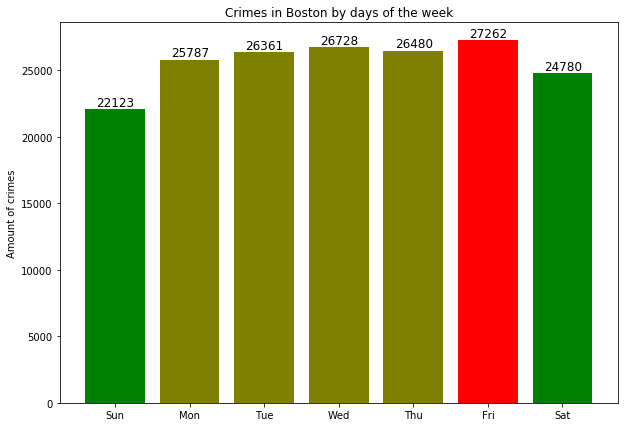

In [129]:
fig = plt.figure(figsize = (10,7))
ax = plt.subplot(111)
ind = np.arange(7)
crimes_by_day = df_day['counts']
rects = ax.bar(ind, crimes_by_day, width = 0.8, color = ['green','olive','olive','olive','olive','red','green'])
ax.set_xticks(ind)
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax.set_title('Crimes in Boston by days of the week')
ax.set_ylabel('Amount of crimes')
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + 0.15, 1.01 * height, height, fontsize = 12)

<a id = 'year'></a>
[Return to top](#top)
## 2.2 Is the crime problem in Boston getting better or worse?

In [80]:
df_year = df_clean.groupby('year').size().reset_index(name = 'counts').set_index('year')

In [81]:
df_year

,counts
year,
2015,30296
2016,50512
2017,48455
2018,47489
2019,2769


Disregarding 2015 and 2019 since there are not enough data about them in the data set it is easy to see that the crime situation in 2017 is slightly better than the situation in 2016. The crime situation in 2018 is slightly better than the situation in 2017.

In [82]:
df_year.drop(labels = [2015,2019], inplace = True)

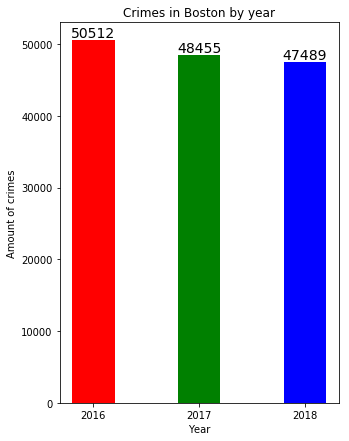

In [142]:
fig2 = plt.figure(figsize = (5,7))
ind2 = np.arange(3)
ax2 = plt.subplot(111)
rects = ax2.bar(ind2, df_year['counts'], width = 0.4, color = ['red','green','blue'])
ax2.set_xticks(ind2)
ax2.set_xticklabels([2016,2017,2018])
ax2.set_xlabel('Year')
ax2.set_ylabel('Amount of crimes')
ax2.set_title('Crimes in Boston by year')
for rect in rects:
    height = rect.get_height()
    ax2.text(rect.get_x() - 0.01, 1.01 * height, height, fontsize = 14)

<a id = 'month'></a>
[Return to top](#top)
## 2.3 Crime and month

Are there more crimes in summers or in winters?

Since the data set is from Aug.2015 to Jan. 2019 let's analyze the trends from 2016 to 2018.

In [89]:
df_1618 = df_clean.loc[(df_clean['year'] > 2015) & (df_clean['year'] < 2019)]

In [90]:
df_1618.shape

(146456, 15)

In [91]:
df_month = df_1618.groupby('month').size().reset_index(name = 'counts').set_index('month')

In [92]:
df_month

,counts
month,
1,11932
2,10765
3,11762
4,12012
5,12949
6,13047
7,13194
8,13348
9,12643


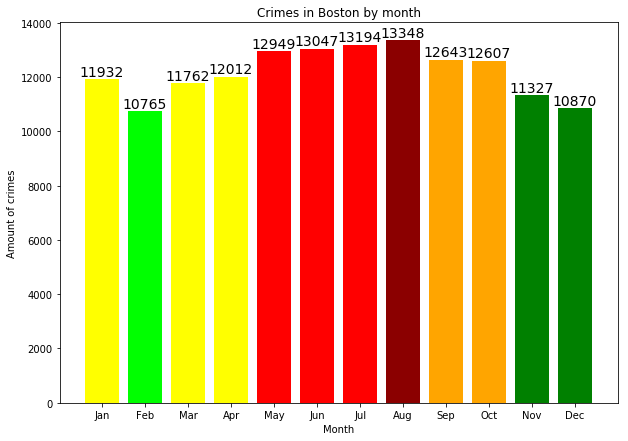

In [152]:
fig3 = plt.figure(figsize = (10,7))
ind3 = np.arange(12)
ax3 = plt.subplot(111)
rects = ax3.bar(ind3, df_month['counts'], width = 0.8,color = ['yellow','lime','yellow','yellow','red','red','red','darkred','orange','orange','green','green'])
ax3.set_xticks(ind3)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax3.set_xlabel('Month')
ax3.set_ylabel('Amount of crimes')
ax3.set_title('Crimes in Boston by month')
for rect in rects:
    height = rect.get_height()
    ax3.text(rect.get_x() - 0.13, 1.01 * height, height, fontsize = 14)

It seems that there is more crime during summer months and less crime during winter ones. It's possible that crime is fairly weather-dependent. Is this trend true for all three full years?

<a id = 'common'></a>
[Return to top](#top)
## 2.4 What are the most common crimes in Boston?

In [93]:
df_ocg = df_clean.groupby('offense_code_group').size().reset_index(name = 'counts').set_index('offense_code_group').sort_values(by = 'counts', ascending = False)

In [94]:
df_ocg

,counts
offense_code_group,
Larceny,29257
Other,19091
Drug Violation,18502
Simple Assault,17799
Vandalism,17132
Larceny From Motor Vehicle,12029
Aggravated Assault,8868
Violations,6730
Fraud,6660


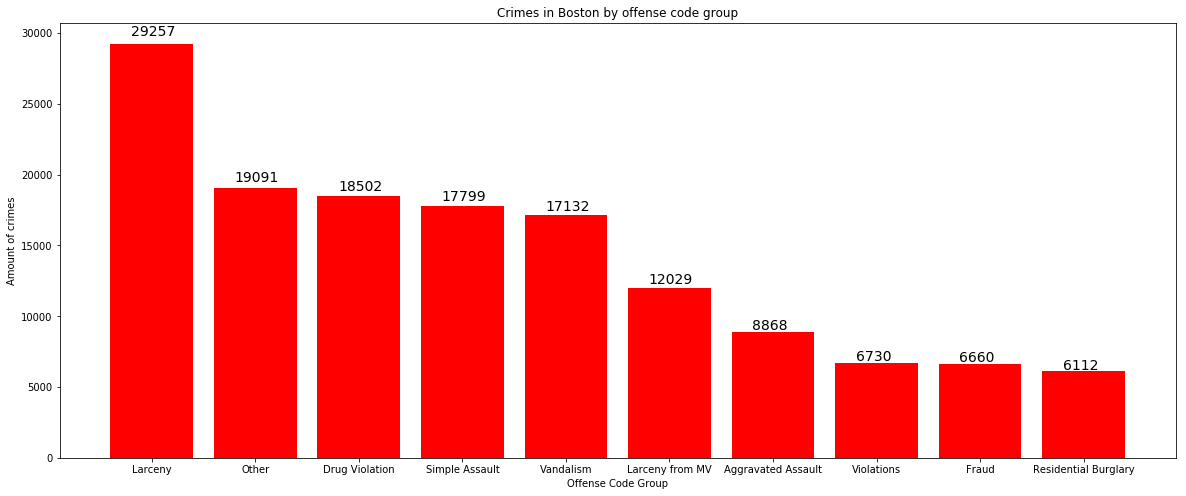

In [177]:
fig41 = plt.figure(figsize = (20,8))
ind41 = np.arange(10)
ax41 = plt.subplot(111)
y_data = df_ocg['counts'].head(10)
df_riocg = df_ocg.reset_index()
rects = ax41.bar(ind41, y_data, width = 0.8,color = 'r')
ax41.set_xticks(ind41)
ax41.set_xticklabels(['Larceny','Other','Drug Violation','Simple Assault','Vandalism','Larceny from MV','Aggravated Assault','Violations','Fraud','Residential Burglary'])
ax41.set_xlabel('Offense Code Group')
ax41.set_ylabel('Amount of crimes')
ax41.set_title('Crimes in Boston by offense code group')
for rect in rects:
    height = rect.get_height()
    ax41.text(rect.get_x() + 0.2, 1.02 * height, height, fontsize = 14)

In [95]:
df_od = df_clean.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description').sort_values(by = 'counts', ascending = False)

In [96]:
df_od

,counts
offense_description,
VANDALISM,16847
ASSAULT SIMPLE - BATTERY,16589
THREATS TO DO BODILY HARM,10233
LARCENY THEFT FROM BUILDING,10199
LARCENY THEFT FROM MV - NON-ACCESSORY,9865
LARCENY SHOPLIFTING,8990
LARCENY ALL OTHERS,6747
ASSAULT - AGGRAVATED - BATTERY,5544
FRAUD - FALSE PRETENSE / SCHEME,5033


<a id = 'location'></a>
[Return to top](#top)
## 2.5 Where are crimes located in Boston?

In [153]:
df_districts = df_clean.groupby('district').size().reset_index(name = 'counts').set_index('district').sort_values('counts', ascending = False)

In [156]:
df_districts

,counts
district,
B2,28366
D4,27516
C11,22960
A1,22268
B3,18252
C6,13459
D14,10336
E13,9925
E18,8593


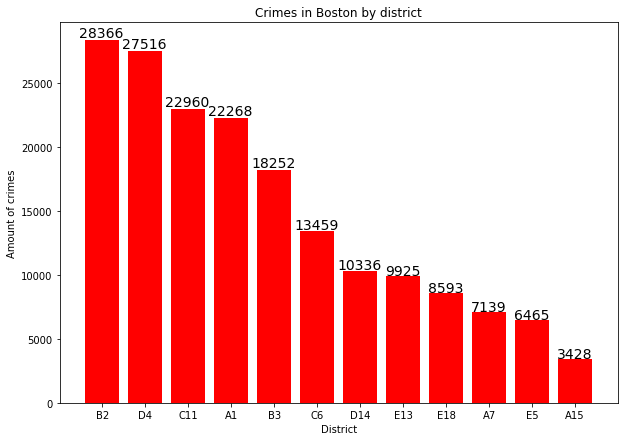

In [199]:
fig5 = plt.figure(figsize = (10,7))
ind5 = np.arange(12)
ax5 = plt.subplot(111)
rects = ax5.bar(ind5, df_districts['counts'], width = 0.8,color = 'r')
ax5.set_xticks(ind5)
ax5.set_xticklabels(df_districts.index)
ax5.set_xlabel('District')
ax5.set_ylabel('Amount of crimes')
ax5.set_title('Crimes in Boston by district')
for rect in rects:
    height = rect.get_height()
    if height > 9999:
        hor = rect.get_x() - 0.13
    else:
        hor = rect.get_x() - 0.03
    ax5.text(hor, 1.01 * height, height, fontsize = 14)

It seems that B2, D4, C11 and A1 have the most crimes. On the other hand A15, A7, E18 and E13 have the least amount of crimes.

Analysis of whether a certain police district of Boston necessarily has more crimes compared to some other police district per capita is impossible because different police district differ a lot in terms of population size.

However analyzing the same information using neighborhood boundaries should be possible.

<a id = 'time'></a>
[Return to top](#top)
## 2.6 What time of day are crimes commited?

In [103]:
df_hour = df_clean.groupby('hour').size().reset_index(name = 'counts').set_index('hour')

In [104]:
df_hour

,counts
hour,
0,9317
1,5511
2,4647
3,2471
4,1857
5,1578
6,2296
7,3895
8,6315


The most crimes are actually commited between 4PM and 8PM. Between 1AM and 8AM few crimes are commited.

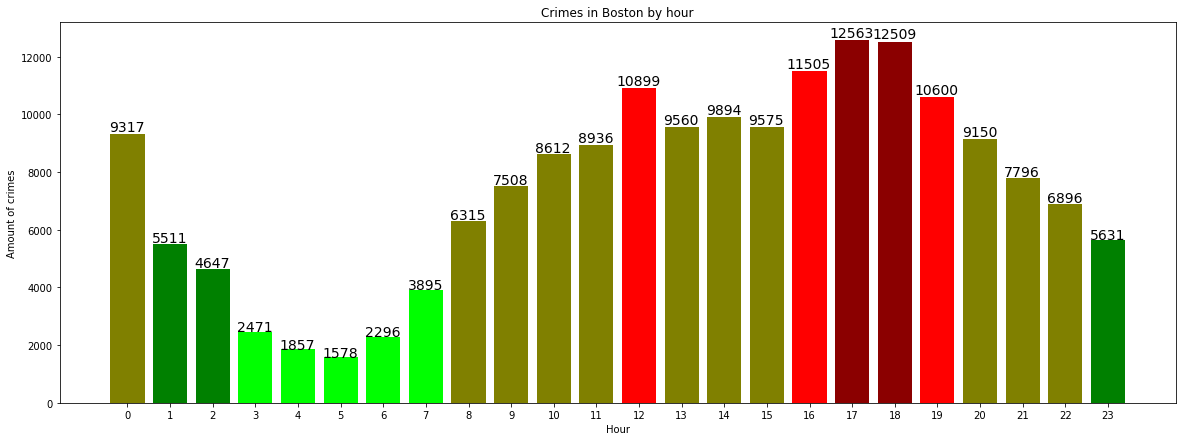

In [196]:
fig6 = plt.figure(figsize = (20,7))
ind6 = np.arange(24)
ax6 = plt.subplot(111)
color = []
for i in range(24):
    amount = df_hour.loc[i, 'counts']
    if amount > 12000:
        color.append('darkred')
    elif amount < 4000:
        color.append('lime')
    elif amount > 10000:
        color.append('r')
    elif amount < 6000:
        color.append('g')
    else:
        color.append('olive')
rects = ax6.bar(ind6, df_hour['counts'], width = 0.8,color = color)
ax6.set_xticks(ind6)
ax6.set_xticklabels(df_hour.index)
ax6.set_xlabel('Hour')
ax6.set_ylabel('Amount of crimes')
ax6.set_title('Crimes in Boston by hour')
for rect in rects:
    height = rect.get_height()
    if height > 9999:
        hor = rect.get_x() - 0.13
    else:
        hor = rect.get_x() - 0.03
    ax6.text(hor, 1.01 * height, height, fontsize = 14)

<a id = 'shooting'></a>
[Return to top](#top)
## 2.7 How many crimes involve shooting?

In [109]:
df_shooting = df_clean.groupby('shooting').size().reset_index(name = 'counts').set_index('shooting')

In [110]:
df_shooting

,counts
shooting,
0,178333
Y,1188


OK so Y represents shooting.

In [111]:
shooting_rate = df_shooting.loc['Y', 'counts']/df_clean.shape[0]

In [112]:
shooting_rate

0.006617610196021635

About 0.66% of all crimes involve shooting.

Text(0.5,1,'What percentage of crimes involve shooting?')

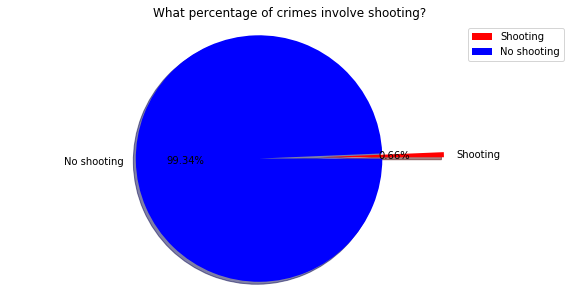

In [198]:
fig7 = plt.figure(figsize = (10,5))
labels = ['Shooting', 'No shooting']
ax7 = plt.subplot(111)
size = [shooting_rate, 1 - shooting_rate]
ax7.pie(size, explode = [0.5,0], labels = labels, autopct = '%1.2f%%', shadow = True, colors = ['red','blue'])
ax7.axis('equal')
ax7.legend()
ax7.set_title('What percentage of crimes involve shooting?')

<a id = 'crime_rates'></a>
[Return to top](#top)
# 3. Crime rates of neighborhoods of Boston

We are going to continue our exploration in 2.5 . It is impossible to calculate the population of police districts. However the population of neighborhoods of Boston are still possible to obtain. We are going to use the definitions of neighborhoods on the [Analyze Boston](http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0) website.

<a id = '3.0'></a>
## 3.1 Calculate the population of each neighborhood of Boston

In [207]:
import json
with open('Boston_Neighborhoods.geojson', 'r') as f:
    boston_geojson = json.load(f)
features = boston_geojson['features']
nbh_list = []
for feature in features:
    nbh_list.append(feature['properties']['Name'])
print(nbh_list)

['Roslindale', 'Jamaica Plain', 'Mission Hill', 'Longwood', 'Bay Village', 'Leather District', 'Chinatown', 'North End', 'Roxbury', 'South End', 'Back Bay', 'East Boston', 'Charlestown', 'West End', 'Beacon Hill', 'Downtown', 'Fenway', 'Brighton', 'West Roxbury', 'Hyde Park', 'Mattapan', 'Dorchester', 'South Boston Waterfront', 'South Boston', 'Allston', 'Harbor Islands']


In [209]:
nbh_list.sort()

In [212]:
nbh_list

['Allston',
 'Back Bay',
 'Bay Village',
 'Beacon Hill',
 'Brighton',
 'Charlestown',
 'Chinatown',
 'Dorchester',
 'Downtown',
 'East Boston',
 'Fenway',
 'Harbor Islands',
 'Hyde Park',
 'Jamaica Plain',
 'Leather District',
 'Longwood',
 'Mattapan',
 'Mission Hill',
 'North End',
 'Roslindale',
 'Roxbury',
 'South Boston',
 'South Boston Waterfront',
 'South End',
 'West End',
 'West Roxbury']

Now it's time to determine the population of each neighborhood. The data is also obtained from [Analyze Boston](https://data.boston.gov/dataset/boston-neighborhood-demographics) because different websites have completely different definitions of many neighborhoods. Here according to the City of Boston Chinatown and Leather district have been merged into Downtown and Bay Village is merged into South End.

In [213]:
nbh_list.remove('Chinatown')
nbh_list.remove('Bay Village')
nbh_list.remove('Leather District')

In [214]:
nbh_list

['Allston',
 'Back Bay',
 'Beacon Hill',
 'Brighton',
 'Charlestown',
 'Dorchester',
 'Downtown',
 'East Boston',
 'Fenway',
 'Harbor Islands',
 'Hyde Park',
 'Jamaica Plain',
 'Longwood',
 'Mattapan',
 'Mission Hill',
 'North End',
 'Roslindale',
 'Roxbury',
 'South Boston',
 'South Boston Waterfront',
 'South End',
 'West End',
 'West Roxbury']

In [220]:
nbh_pop = {
    'Allston':22312,
 'Back Bay':16622,
 'Beacon Hill':9023,
 'Brighton':52685,
 'Charlestown':16439,
 'Dorchester':114249,
 'Downtown':15992,
 'East Boston':40508,
 'Fenway':33895,
 'Harbor Islands':535,
 'Hyde Park':32317,
 'Jamaica Plain':35541,
 'Longwood':4861,
 'Mattapan':22500,
 'Mission Hill':16874,
 'North End':8608,
 'Roslindale':26368,
 'Roxbury':49111,
 'South Boston':31110,
 'South Boston Waterfront':2564,
 'South End':29612,
 'West End':5423,
 'West Roxbury':30445
}

In [222]:
df_nb = pd.DataFrame.from_dict(data = nbh_pop, orient = 'index', columns = ['population'])

In [223]:
df_nb

,population
Allston,22312
Back Bay,16622
Beacon Hill,9023
Brighton,52685
Charlestown,16439
Dorchester,114249
Downtown,15992
East Boston,40508
Fenway,33895
Harbor Islands,535


We need to preserve the data.

In [224]:
df_nb.to_csv('population.csv')

<a id = '3.1'></a>
[Return to top](#top)
## 3.2 Determining the neighborhood in which a crime took place

Since we already have the information about 